In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np

INPUT_FILE = "./outputs/master_monthly.csv"
OUTPUT_TBL_DIR = "./outputs/tables"
OUTPUT_FIG_DIR = "./outputs/figures"

# Ensure dirs exist
os.makedirs(OUTPUT_TBL_DIR, exist_ok=True)
os.makedirs(OUTPUT_FIG_DIR, exist_ok=True)

# Data Preparation
Load the master dataset, filter for the latest available month, and clean the data ensuring no negative or missing growth values.

In [ ]:
df = pd.read_csv(INPUT_FILE)

latest_month = df['month_year'].max()
print(f"Latest Month: {latest_month}")

df_latest = df[df['month_year'] == latest_month].copy()

# Filter active locations (assi > 0)
df_latest = df_latest[df_latest['assi'] > 0]

if 'assi_mom' not in df_latest.columns:
    df_latest['assi_mom'] = 0
df_latest['assi_mom'] = df_latest['assi_mom'].fillna(0)

print(f"Active locations for segmentation: {len(df_latest)}")

Latest Month: 2025-12
Active locations for segmentation: 28578


# Quadrant Segmentation
Calculate median thresholds for ASSI and Growth Rate. Assign each location to one of four quadrants based on these thresholds.

In [ ]:
# 3. Calculate Thresholds (Medians)
median_assi = df_latest['assi'].median()
median_mom = df_latest['assi_mom'].median()

print(f"Median ASSI: {median_assi:.2f}")
print(f"Median Growth: {median_mom:.2f}")

# 4. Assign Quadrants
def get_quadrant(row):
    high_assi = row['assi'] >= median_assi
    high_growth = row['assi_mom'] >= median_mom
    
    if high_assi and high_growth: return "Q1: Immediate Scaling"
    if high_assi and not high_growth: return "Q2: Permanent Capacity"
    if not high_assi and high_growth: return "Q3: Emerging Monitor"
    return "Q4: Stable Baseline"

df_latest['quadrant_label'] = df_latest.apply(get_quadrant, axis=1)

out_seg = os.path.join(OUTPUT_TBL_DIR, "priority_segmentation_latest_month.csv")
df_latest.to_csv(out_seg, index=False)
print(f"Saved segmentation: {out_seg}")

Median ASSI: 23.80
Median Growth: 0.01
Saved segmentation: ./outputs/tables/priority_segmentation_latest_month.csv


# Visualization and Summary
Generate a scatter plot visualizing the quadrants and a summary table showing the distribution of locations across these strategic categories.

Saved plot: ./outputs/figures/priority_quadrant.png


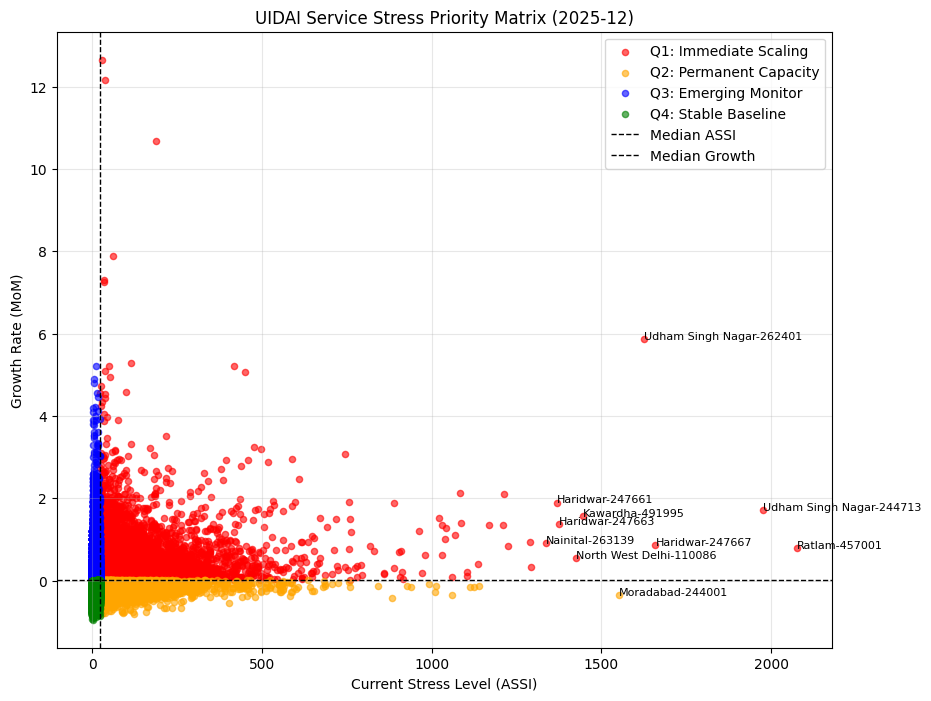

Summary table saved.


,Quadrant,Count,Share (%)
0,Q1: Immediate Scaling,7963,27.9
1,Q4: Stable Baseline,7950,27.8
2,Q2: Permanent Capacity,6339,22.2
3,Q3: Emerging Monitor,6326,22.1


In [ ]:
# 5. Quadrant Plot
plt.figure(figsize=(10, 8))

# Scatter points colored by quadrant
colors = {'Q1: Immediate Scaling': 'red', 
          'Q2: Permanent Capacity': 'orange',
          'Q3: Emerging Monitor': 'blue',
          'Q4: Stable Baseline': 'green'}

for label, color in colors.items():
    subset = df_latest[df_latest['quadrant_label'] == label]
    plt.scatter(subset['assi'], subset['assi_mom'], alpha=0.6, s=20, label=label, color=color)

# Draw Reference Lines
plt.axvline(median_assi, color='black', linestyle='--', linewidth=1, label='Median ASSI')
plt.axhline(median_mom, color='black', linestyle='--', linewidth=1, label='Median Growth')

# Annotate Top 10 ASSI
top_10 = df_latest.nlargest(10, 'assi')
for _, row in top_10.iterrows():
    plt.text(row['assi'], row['assi_mom'], f"{row['district']}-{row['pincode']}", fontsize=8)

plt.title(f"UIDAI Service Stress Priority Matrix ({latest_month})")
plt.xlabel("Current Stress Level (ASSI)")
plt.ylabel("Growth Rate (MoM)")
plt.legend()
plt.grid(True, alpha=0.3)

out_plot = os.path.join(OUTPUT_FIG_DIR, "priority_quadrant.png")
plt.savefig(out_plot, dpi=150)
print(f"Saved plot: {out_plot}")
plt.show()


quad_summary = df_latest['quadrant_label'].value_counts().reset_index()
quad_summary.columns = ['Quadrant', 'Count']
quad_summary['Share (%)'] = (quad_summary['Count'] / len(df_latest) * 100).round(1)

out_sum = os.path.join(OUTPUT_TBL_DIR, "quadrant_summary.csv")
quad_summary.to_csv(out_sum, index=False)
print("Summary table saved.")
quad_summary